# Task 4

## The Analytical Solution

We are looking to analsyse some idealised profiles of data on a 1D grid. 

For non-divergent flow, under geostrophic balance, the vorticity equation is given by:
$$ \xi = \frac{2A}{L^2_y} \frac{\phi_0}{f_0} \tanh{\left(\frac{y-y_0}{L_y}\right)} \left[1 - \tanh^2 (\frac{y-y_0}{L_y})\right]$$

We also have the horizontal velocity, u, given by:
$$ u = \frac{A}{L_y} \frac{\phi_0}{f_0} \left[1 - \tanh^2 (\frac{y-y_0}{L_y})\right]$$

And we have the stream function given by:
$$ \Psi = \frac{\Phi_0}{f_0} \left[ 1 - A \tanh{\left(\frac{y-y_0}{L_y}\right)}\right] $$

In this task we want to calculate and plot $\Psi(y)$, $u(y)$ and $\xi(y)$ for the following parameters:

- $\phi_0 = 10^{5}$ metres squared per second squared
- $A = 10^{-4}$ per second
- $L_y = 10^{5}$ metres
- $A = 5 \times 10^{-3}$
- $y_0 = 5 \times 10^5$: metres

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from scipy.linalg import solve

plt.style.use('science')

## Solution

We first create a grid with $\Delta y = 10^4 \; \text{m}$, from $y_0 = 0 \; \text{m}$ to $y = 10^6 \; \text{m}$.

In [2]:
y = np.arange(0, 10**6, 10000)

Then define all constants:

In [3]:
phi_0 = 1e5
f_0 = 1e-4
L_y = 1e5
A = 5e-3

y_0 = 5e05

We also define a simple tanh function to simplify the syntax.

In [4]:
def tanh(x):
    return np.tanh(x)

Now we calculate the stream function, u and vorticity:

In [5]:
vorticity = (2*A/(L_y**2)) * (phi_0/f_0) * tanh((y-y_0)/L_y) * (1 - ((tanh((y-y_0)/L_y))**2))

u = A/L_y * phi_0/f_0 * (1 - ((tanh((y-y_0)/L_y))**2))

streamfunction = phi_0/f_0 * (1 - (A * (tanh((y-y_0)/L_y))))

And we visualise the results:

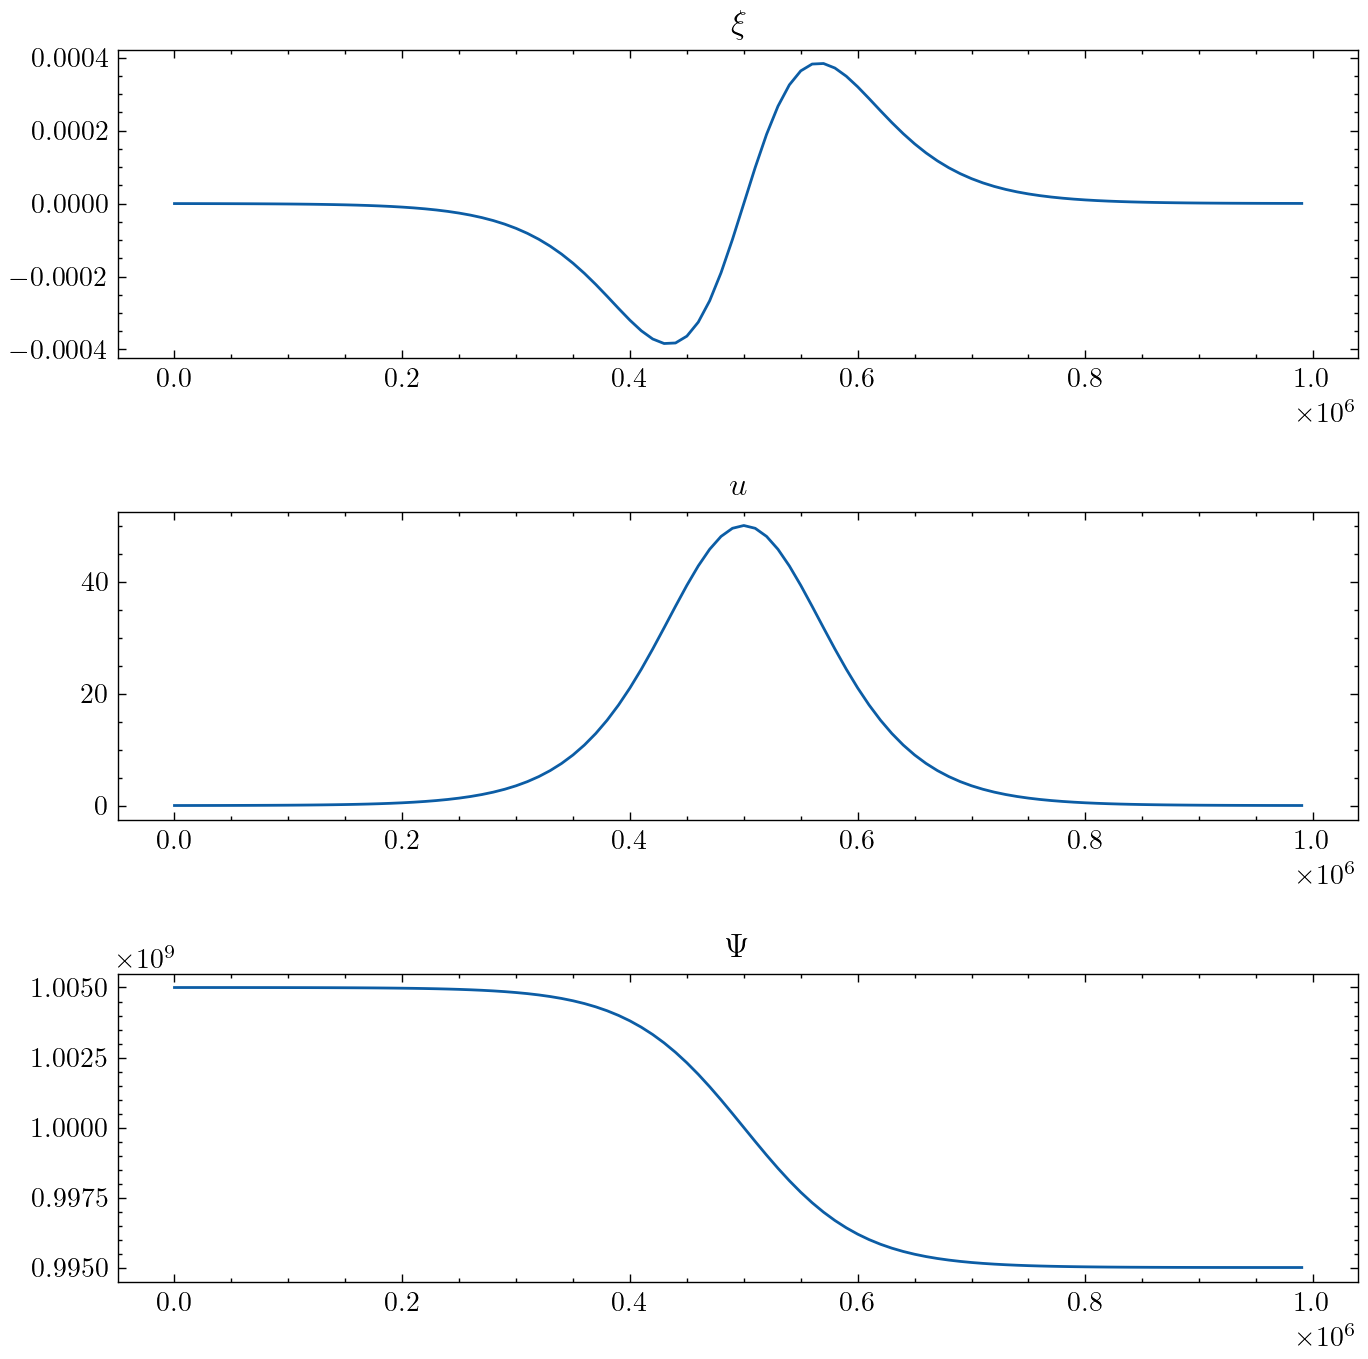

In [6]:
fig, ax = plt.subplots(3, 1, figsize=(8,8), dpi=200)
ax[0].plot(y, vorticity, label=r'$\xi$')
ax[1].plot(y, u, label=r'$u$')
ax[2].plot(y, streamfunction, label=r'$\Psi$')

ax[0].set_title(r'$\xi$')
ax[1].set_title(r'$u$')
ax[2].set_title(r'$\Psi$')

fig.subplots_adjust(hspace=0.5)

## Finite Difference Forms

We also have these forms of the same equations:

$$ u = -\frac{\partial \Psi}{\partial y} $$

$$ \xi = \frac{\partial^2 \Psi}{\partial y^2} $$

For the velocity, we can use a central difference scheme:
$$ u = \frac{\Psi_{i+1} - \Psi_{i-1}}{2 \Delta y} $$

This gives us a second order accurate scheme, however, we must account for the boundary conditions. We can use a forward difference scheme for the first point: 
$$ u_0 = \frac{\Psi_{1} - \Psi_{0}}{\Delta y} $$

And a backward difference scheme for the last point:
$$ u_i = \frac{\Psi_{i} - \Psi_{i-1}}{\Delta y} $$

Now we can code up a solution for the velocity field using these schemes:

### Flow Speed

In [7]:
def generate_velocity(streamfunction, y):
    # initiate variables and constants
    u = np.zeros(np.shape(y)[0])
    dy = y[1]-y[0]

    # calculate the first value using the forward euler approximation
    u[0] = -1 * ((streamfunction[1] - streamfunction[0]) / dy)

    # calculate the rest of the values using the centred difference approximation
    for i in range(1, np.shape(y)[0]-1):
        u[i] = -1 * ((streamfunction[i+1] - streamfunction[i-1]) / (2 * dy))

    # calculate the last value of the array using the backward euler approximation
    u[-1] = -1 * ((streamfunction[-1] - streamfunction[-2]) / dy)

    return u

numerical_u = generate_velocity(streamfunction, y)

And now we can visualise the results:

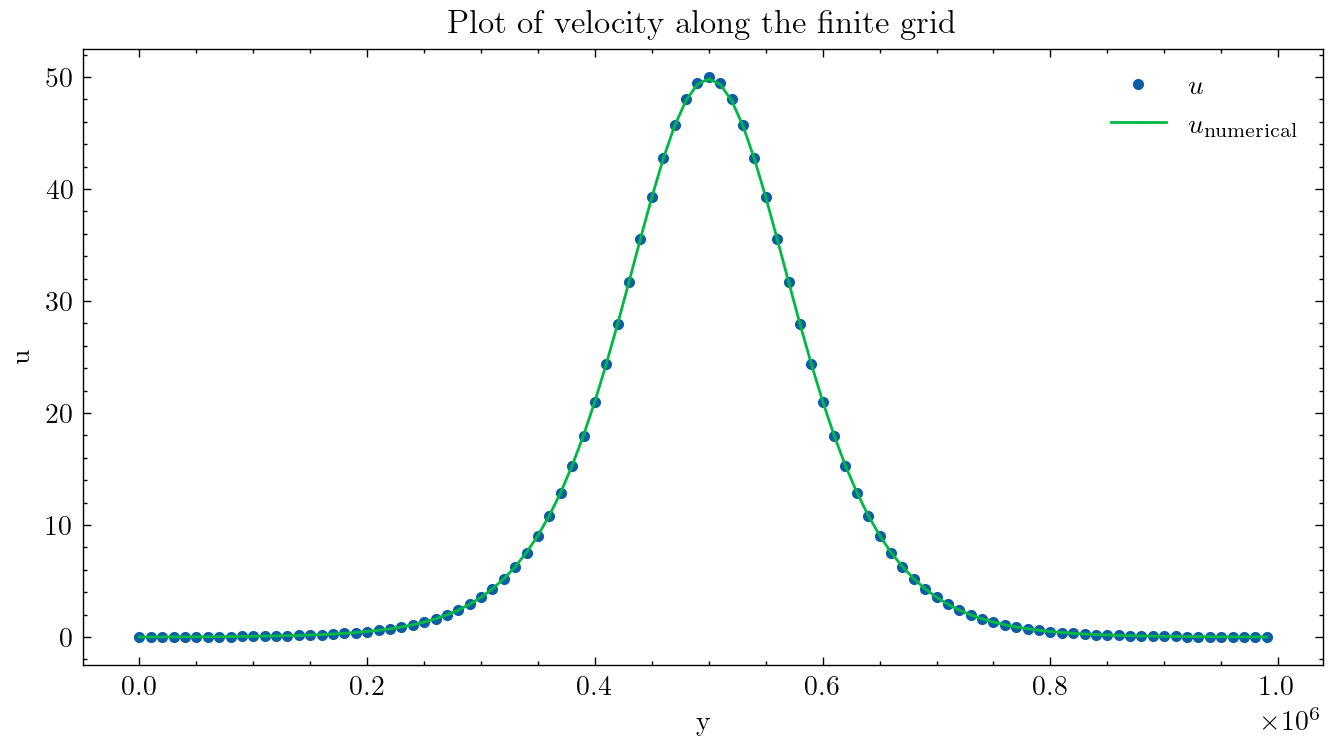

In [8]:
fig, ax = plt.subplots(figsize=(8,4), dpi = 200)
ax.plot(y, u, '.', label=r'$u$')
ax.plot(y, numerical_u, label=r'$u_{\text{numerical}}$')
ax.set_title(r'Plot of velocity along the finite grid')
ax.set_xlabel('y')
ax.set_ylabel('u')
plt.legend()

plt.show()

### Vorticity

We can approximate the second derivative as follows:

$$ \frac{\partial^2 \Psi}{\partial y^2} \approx \frac{\Psi_{i+1} - 2\Psi_i + \Psi_{i-1}}{\Delta y^2} $$

Which we code as follows:

In [9]:
def generate_vorticity(streamfunction, y):
    # initiate variables and constants
    N = np.shape(y)[0]
    psi = np.zeros(N)
    dy = y[1]-y[0]
    
    # implement the 3-point central difference approximation
    for i in range(1,N-1): # loop through the values betweeen the first and last value as they cannot be calculated using the 3-point central difference approximation
        psi[i] = (streamfunction[i+1] - (2 * streamfunction[i]) + streamfunction[i-1]) / (dy**2)
            
    return psi

numerical_vorticity = generate_vorticity(streamfunction, y)

Visualise results

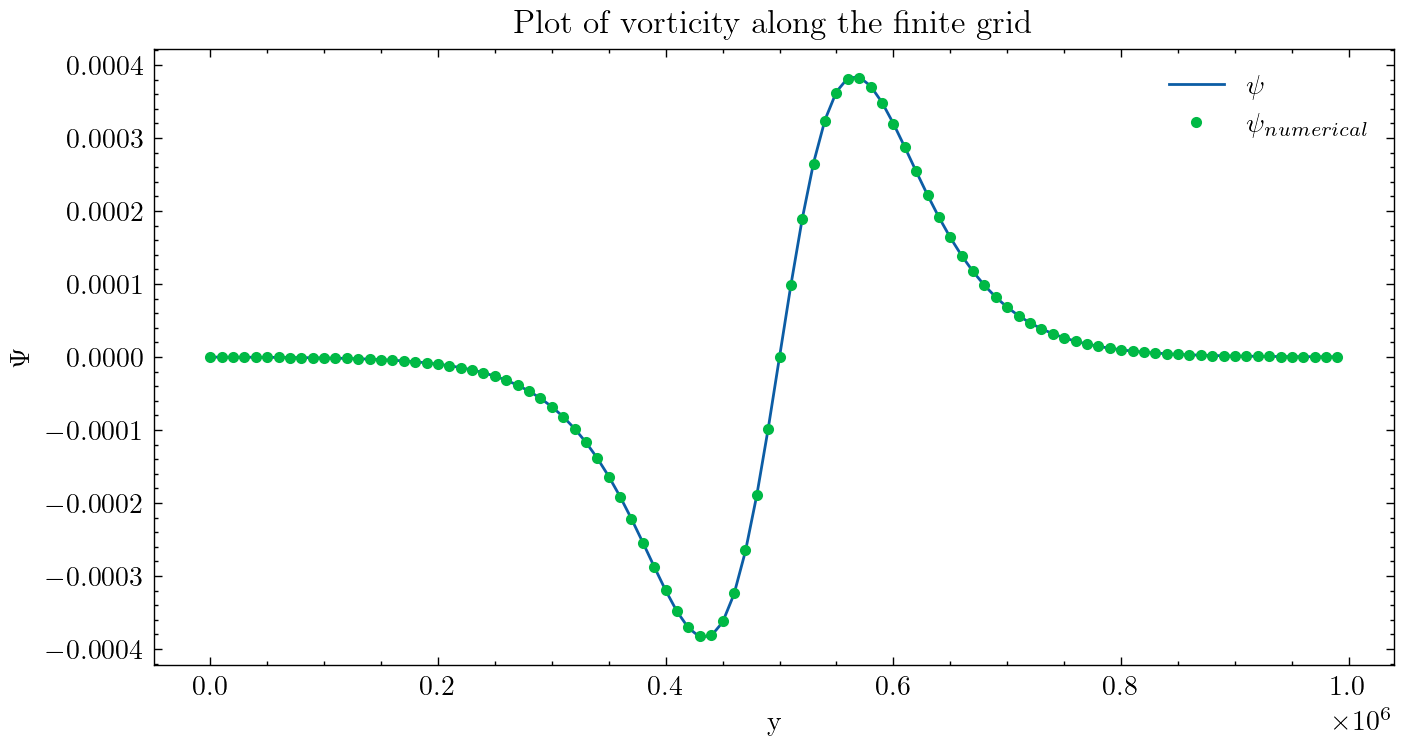

In [10]:
fig, ax = plt.subplots(figsize=(8,4), dpi = 200)
ax.plot(y, vorticity, label=r'$\psi$')
ax.plot(y, numerical_vorticity, '.', label=r'$\psi_{numerical}$')
ax.set_title(r'Plot of vorticity along the finite grid')
ax.set_xlabel('y')
ax.set_ylabel(r'$\Psi$')
plt.legend()

plt.show()

## Inverting Vorticity to Obtain Streamfunction

Now we want to solve the problem:

$$ \frac{\partial^2 \Psi}{\partial y^2} = \xi $$

We can represent this as a system of linear equations. For example, if we have 4 latitude points, we can write the system as:

$$ B = \begin{pmatrix} 1 & 0 & 0 & 0 \\ F & -2F & F & 0 \\ 0 & F & -2F & F \\ 0 & 0 & 0 & 1 \end{pmatrix} \begin{pmatrix} \Psi_1 \\ \Psi_2 \\ \Psi_3 \\ \Psi_4 \end{pmatrix} = \begin{pmatrix} \Psi_1 \\ \xi_2 \\ \xi_3 \\ \Psi_4 \end{pmatrix}$$


To implement this solution, we first need to construct a tri-diagonal matrix. So we define the function as follows:

In [11]:
def generate_tridiagonal_matrix(N):

    # define variables and constants
    y = np.arange(0, 10**6, 10000)
    dy = y[1]-y[0]

    # initiate matrix
    matrix = np.zeros((N,N))
    F = 1/(dy**2)

    # fill the matrix with the correct values by looping through the rows first, then the columns:
    for i in range(N): 
        for j in range(N): 

            # fill the corners of the matrix with 1:
            if (i == j == 0) or (i == j == N-1): 
                matrix[i,j] = 1 
                
            # fill the rest of the matrix with the correct values    
            else:

                # if the row and column are the same, fill the diagonal with -2F
                if i == j: 
                    matrix[i,j] = -2*F

                # if the row and column are next to each other, fill the matrix with F
                elif (i == j+1 or i == j-1) and (i != 0 and i != N-1):
                    matrix[i,j] = F

    return matrix

In [12]:
tri_diag_matrix = generate_tridiagonal_matrix(100)

We calculate the boundaries as follows (as we don't want to use the streamfunction values we've calculated already, just so we can see if our method actually works). For the northern boundary we have:
$$ \frac{\phi_0}{f_0}(1+A) $$

And for the southern boundary we have:
$$ \frac{\phi_0}{f_0}(1-A) $$

Which is very simply coded:

In [13]:
northern_boundary = (phi_0/f_0) * (1+A)
southern_boundary = (phi_0/f_0) * (1-A)

Now we define a vector of 'right-hand-side' terms using analytical vorticity values:

In [14]:
# first we copy the numerical vorticity array because the majority of the RHS vector is composed of the same vallues
solution_vector  = vorticity

# then we set the first and last value to the first and last values of the streamfunction
solution_vector[0], solution_vector[-1] = northern_boundary, southern_boundary

And we try the same with the numerical vorticity values:

In [15]:
solution_vector2 = numerical_vorticity
solution_vector2[0], solution_vector2[-1] = northern_boundary, southern_boundary

Now we can obtain the streamfunction by solving the system of linear equations using linear algebra

In [16]:
inverted_streamfunction_analytical = solve(tri_diag_matrix, solution_vector)
inverted_streamfunction_numerical = solve(tri_diag_matrix, solution_vector2)

Visualise results

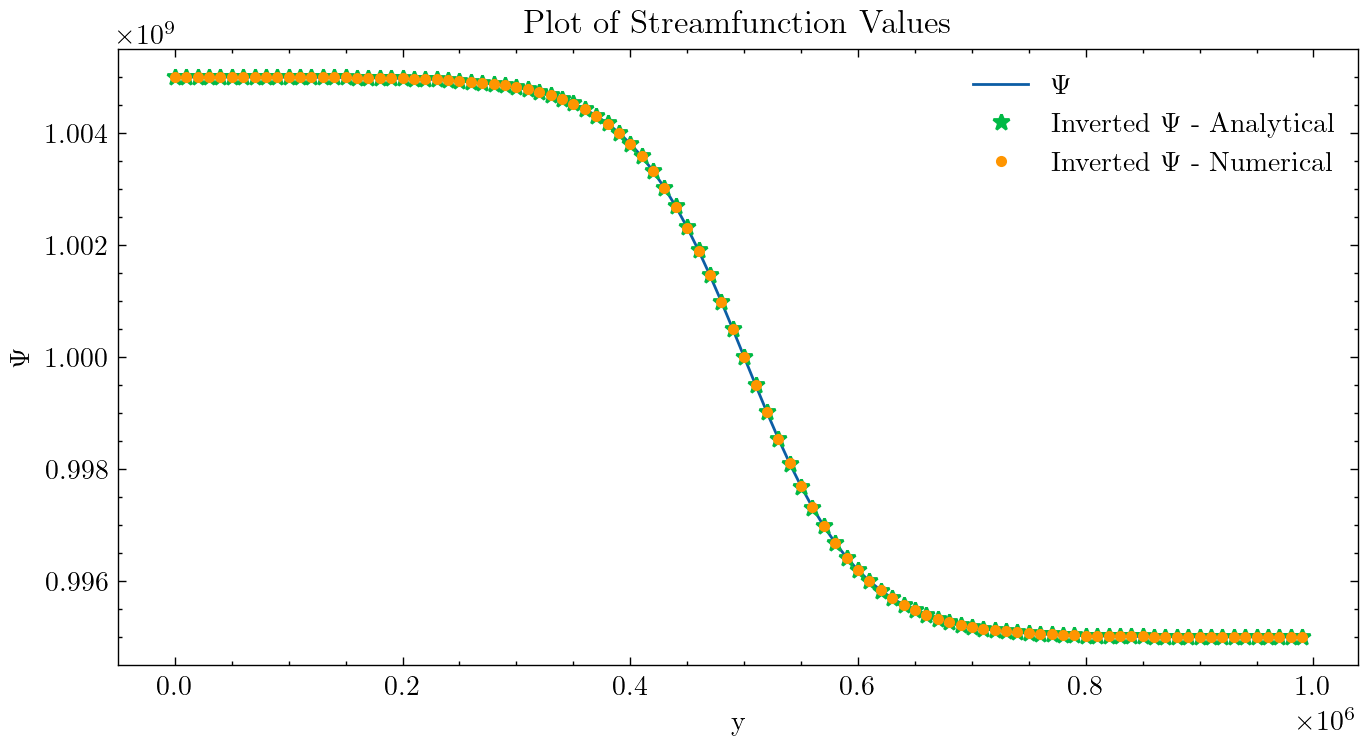

In [17]:
fig, ax = plt.subplots(figsize=(8,4), dpi = 200)
ax.plot(y, streamfunction, label=r'$\Psi$')
ax.plot(y, inverted_streamfunction_analytical, '*', label=r'Inverted $\Psi$ - Analytical')
ax.plot(y, inverted_streamfunction_numerical, '.', label=r'Inverted $\Psi$ - Numerical')
ax.set_ylabel(r'$\Psi$')
ax.set_xlabel('y')
ax.set_title('Plot of Streamfunction Values')

plt.legend()
plt.show()